# Loading data and $0^{\text{th}}$ order EDA

In [1]:
# Load the required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/anaconda3/bin/python
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)


In [3]:
# Read the original file
original_path = 'data/original.xlsx'
orig_xls = pd.ExcelFile(original_path)
print(orig_xls.sheet_names)

['Training_set_Staphiloccocus', 'Test_set_Staphiloccocus']


In [4]:
# import the excel sheets separately
df1 = orig_xls.parse('Training_set_Staphiloccocus')
df2 = orig_xls.parse('Test_set_Staphiloccocus')

In [5]:
# import the extra data that we have
additional_path = 'data/additional.xlsx'
addit_xls = pd.ExcelFile(additional_path)
print(addit_xls.sheet_names)

['Sheet1', 'Sheet2']


In [6]:
# there is one more column -- 'Sequence', that we remove to match the rest of the data
df3 = addit_xls.parse('Sheet1').drop(['Sequence'], axis=1)

In [7]:
print(df1.shape, df2.shape, df3.shape)

(298, 13) (74, 13) (52, 13)


In [8]:
# merge the three excel sheets into the training + validation data + test
df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                424 non-null    float64
 1   Normalized Hydrophobicity                    424 non-null    float64
 2   Net Charge                                   424 non-null    int64  
 3   Isoelectric Point                            424 non-null    float64
 4   Penetration Depth                            424 non-null    int64  
 5   Tilt Angle                                   424 non-null    int64  
 6   Propensity to Disordering                    424 non-null    float64
 7   Linear Moment                                424 non-null    float64
 8   Propensity to in vitro Aggregation           424 non-null    float64
 9   Angle Subtended by the Hydrophobic Residues  424 non-null    int64  
 10  Am

In [9]:
# check for duplicates
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 423
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                408 non-null    float64
 1   Normalized Hydrophobicity                    408 non-null    float64
 2   Net Charge                                   408 non-null    int64  
 3   Isoelectric Point                            408 non-null    float64
 4   Penetration Depth                            408 non-null    int64  
 5   Tilt Angle                                   408 non-null    int64  
 6   Propensity to Disordering                    408 non-null    float64
 7   Linear Moment                                408 non-null    float64
 8   Propensity to in vitro Aggregation           408 non-null    float64
 9   Angle Subtended by the Hydrophobic Residues  408 non-null    int64  
 10  Am

### $\color{red}{\textbf{Correlations bewteen features}}$

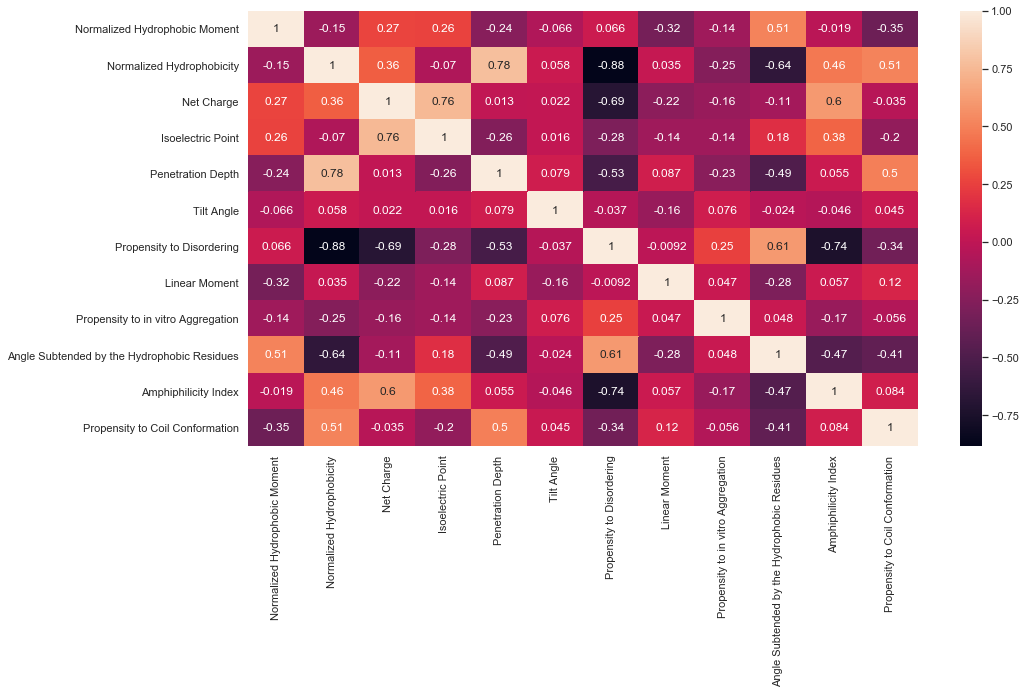

In [11]:
# Correlation matrix 
plt.figure(figsize=(15,8))
corr_mat = df.drop('Class', axis=1).corr()
sns.heatmap(corr_mat, annot=True)
plt.show()

In [12]:
# The strongest correlation is between 'Propensity to Disordering' and 'Normalized Hydrophobicity'
unwrapped = np.abs(corr_mat.values.reshape((1,-1)))
max_abs_cor = unwrapped[unwrapped < 1].max()
print(max_abs_cor)

0.8819973411717634


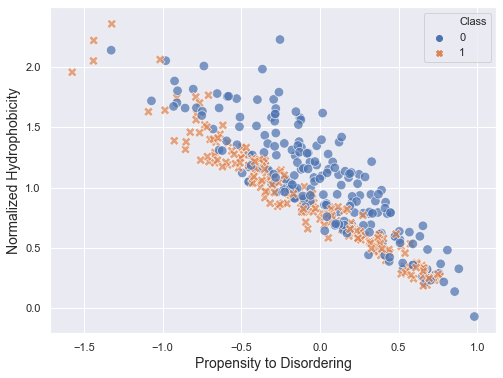

In [13]:
sns.scatterplot(x = 'Propensity to Disordering', y = 'Normalized Hydrophobicity', hue = 'Class', 
                style = 'Class', data = df, s = 90, alpha = 0.7)
plt.xlabel('Propensity to Disordering', fontsize = 14)
plt.ylabel('Normalized Hydrophobicity', fontsize = 14)
plt.show()

### $\color{red}{\textbf{PCA}}$

In [14]:
# Let's check if one can reduce dimensionality. For PCA to make sense, standardize data!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

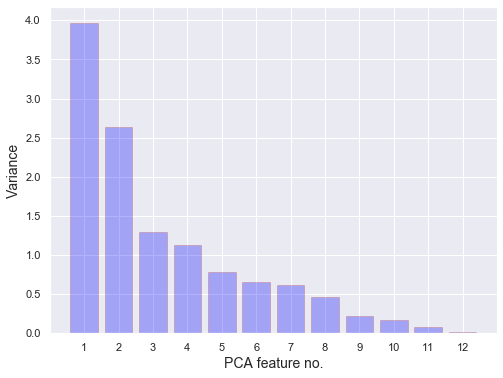

In [15]:
pca_transformer = PCA()
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
plt.bar(features, pca_transformer.explained_variance_, color='blue', edgecolor='r', alpha=0.3)
plt.xticks(features)
plt.xlabel('PCA feature no.', fontsize = 14)
plt.ylabel('Variance', fontsize = 14)
plt.show()

In [16]:
# The data is NOT lower-dimensional, but let's anyway check if the 2-component PCA would separate classes

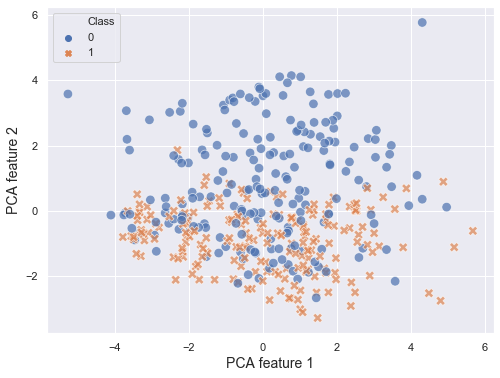

In [17]:
pca_transformer = PCA(n_components=2)
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
sns.scatterplot(x = pca_feat_matrix[:,0], y = pca_feat_matrix[:,1], hue = df['Class'], style = df['Class'], marker='o', 
            s=90, alpha=0.7)
plt.xlabel('PCA feature 1', fontsize=14)
plt.ylabel('PCA feature 2', fontsize =14)
plt.show()

# Fitting and predicting using RandomizedSearchCV()

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [19]:
# split into features and labels (and transform to np arrays)
X = df.drop(['Class'], axis=1).values
y = df['Class'].values
print(X.shape, y.shape)

(408, 12) (408,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### $\color{red}{\textbf{Random Forest}}$

In [21]:
# number of trees in the model
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# how many features to consider at each split
max_features = ['auto', 'sqrt']
# maximum depth of a single tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# min how many samples in a node to split it
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
rf = RandomForestClassifier()
# we will use 3 folds CV and search across 100 different combinarions of the parameters
clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
clf.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


In [100]:
# best classifier parameters
params = clf.best_params_
print(params)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [101]:
best_clf = RandomForestClassifier(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'], 
                                  min_samples_leaf=params['min_samples_leaf'], max_features=params['max_features'], 
                                  max_depth=params['max_depth'], bootstrap=params['bootstrap'])
best_clf.fit(X_train, y_train);

In [102]:
# classification report
y_test_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        38
           1       0.76      0.80      0.78        44

    accuracy                           0.76        82
   macro avg       0.76      0.75      0.75        82
weighted avg       0.76      0.76      0.76        82



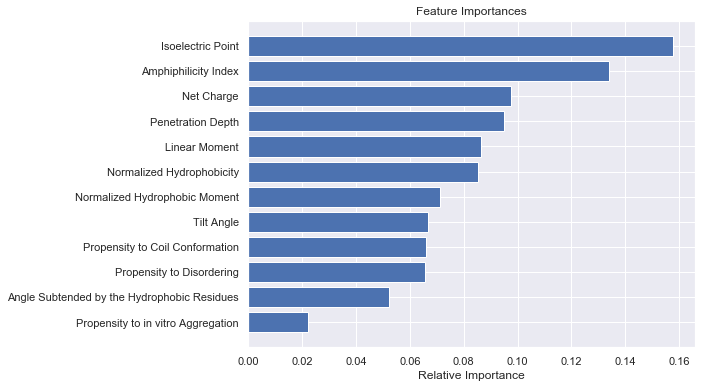

In [103]:
features = df.drop(['Class'], axis=1).columns.tolist()
importances = best_clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### $\color{red}{\textbf{XGBoost}}$

In [104]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1500, num = 10)]
learning_rate = np.logspace(-4, 2, num=10)

parameter_grid = {'learning_rate': learning_rate,
                 'n_estimators': n_estimators}

xgb = XGBClassifier()

In [105]:
clf = GridSearchCV(estimator = XGBClassifier(), param_grid = parameter_grid, cv = 3, verbose=2, n_jobs = -1)
# fit the random search model
clf.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.4s finished


In [106]:
params = clf.best_params_
print(params)

{'learning_rate': 0.21544346900318823, 'n_estimators': 1500}


In [107]:
best_clf = XGBClassifier(n_estimators=params['n_estimators'],
                                  learning_rate=params['learning_rate'])
best_clf.fit(X_train, y_train);

In [108]:
# classification report
y_test_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        38
           1       0.78      0.80      0.79        44

    accuracy                           0.77        82
   macro avg       0.77      0.77      0.77        82
weighted avg       0.77      0.77      0.77        82



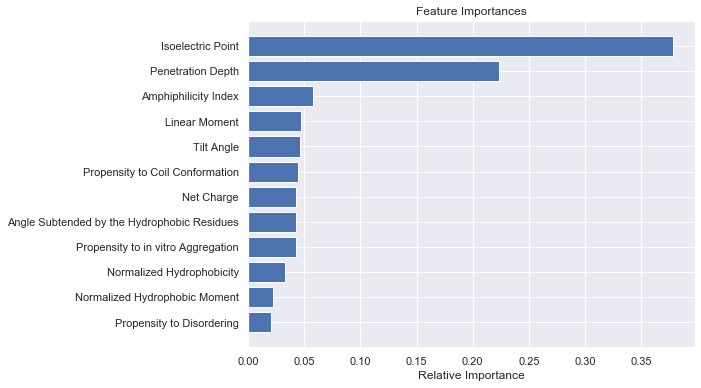

In [109]:
features = df.drop(['Class'], axis=1).columns.tolist()
importances = best_clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### $\color{red}{\textbf{SVM}}$

In [100]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])
parameters = [{'svm__kernel': ['rbf'], 'svm__gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                     'svm__C': [0.001, 0.1, 1, 10, 100, 1000]},
                    {'svm__kernel': ['linear'], 'svm__C': [0.001, 0.1, 1, 10, 100, 1000]}]
clf = GridSearchCV(pipeline, parameters)
clf.fit(X_train, y_train);

In [101]:
params = clf.best_params_
print(params)

{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


In [102]:
best_clf = SVC(C=params['svm__C'], gamma=params['svm__gamma'], kernel=params['svm__kernel'])
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('svm', best_clf)])

pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78        48
           1       0.67      0.94      0.78        34

    accuracy                           0.78        82
   macro avg       0.80      0.80      0.78        82
weighted avg       0.83      0.78      0.78        82



### $\color{red}{\textbf{k nearest neighbours}}$

In [75]:
# define a function that performs CV together with normalisation of data and plots accuracy vs k

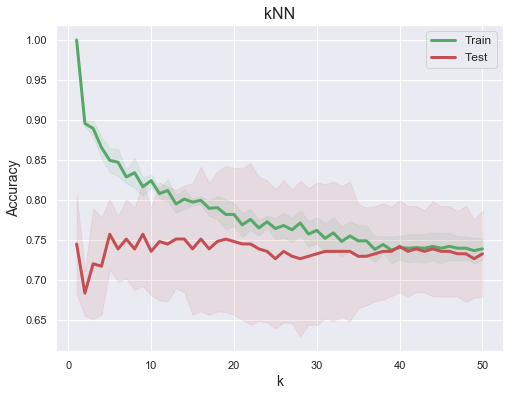

In [106]:
def kNNpredict_uniform(k, X, y):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k, weights='uniform'))
    scores = cross_validate(clf, X, y, cv=5, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

k_list = np.asarray([*range(1, 51)])
train_accuracies = np.asarray([kNNpredict_uniform(k, X_train, y_train)['train_mean'] for k in k_list])
train_stds = np.asarray([kNNpredict_uniform(k, X_train, y_train)['train_std'] for k in k_list])
plt.plot(k_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(k_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([kNNpredict_uniform(k, X_train, y_train)['test_mean'] for k in k_list])
test_stds = np.asarray([kNNpredict_uniform(k, X_train, y_train)['test_std'] for k in k_list])
plt.plot(k_list, test_accuracies, 'r', linewidth = 3)
plt.fill_between(k_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('kNN', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.show()

In [116]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = KNeighborsClassifier(n_neighbors=8, weights='uniform')
clf.fit(X_train_scaled, y_train)
y_test_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        48
           1       0.65      0.76      0.70        34

    accuracy                           0.73        82
   macro avg       0.73      0.74      0.73        82
weighted avg       0.74      0.73      0.73        82



In [ ]:
#----------------------END HERE---------------------------#

### $\color{red}{\textbf{Decision trees}}$

In [78]:
# Trees do not generally require standardisation of data, so we will no include the latter

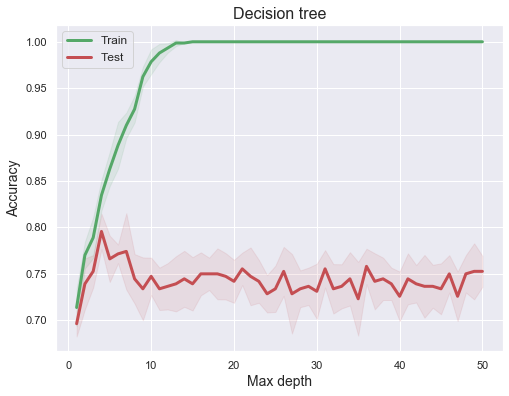

In [79]:
def TreePredict(depth, X, y):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

depth_list = np.asarray([*range(1, 51)])
train_accuracies = np.asarray([TreePredict(depth, X, y)['train_mean'] for depth in depth_list])
train_stds = np.asarray([TreePredict(depth, X, y)['train_std'] for depth in depth_list])
plt.plot(depth_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(depth_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([TreePredict(depth, X, y)['test_mean'] for depth in depth_list])
test_stds = np.asarray([TreePredict(depth, X, y)['test_std'] for depth in depth_list])
plt.plot(depth_list, test_accuracies, 'r', linewidth = 3)
plt.fill_between(depth_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('Decision tree', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Max depth', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [80]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846

### $\color{red}{\textbf{Logistic regression}}$


In [81]:
# Let us try logreg both with and without data standardization. First standardise

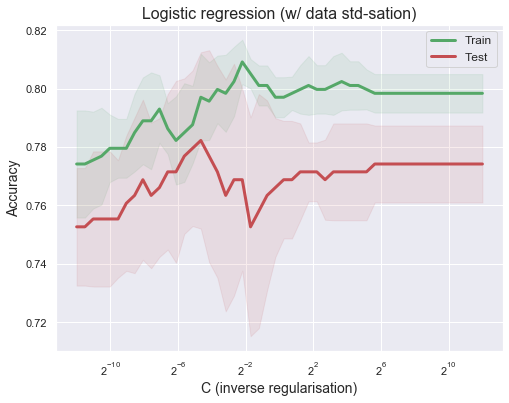

In [82]:
def LogRegPredict(C, X, y):
    clf = make_pipeline(StandardScaler(), LogisticRegression(C=C, solver='liblinear'))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

C_list = np.logspace(-12, 12, base = 2.)
train_accuracies = np.asarray([LogRegPredict(C, X, y)['train_mean'] for C in C_list])
train_stds = np.asarray([LogRegPredict(C, X, y)['train_std'] for C in C_list])
plt.plot(C_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(C_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([LogRegPredict(C, X, y)['test_mean'] for C in C_list])
test_stds = np.asarray([LogRegPredict(C, X, y)['test_std'] for C in C_list])
plt.plot(C_list, test_accuracies, 'r', linewidth = 3)
plt.xscale('log', basex=2)
plt.fill_between(C_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('Logistic regression (w/ data std-sation)', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('C (inverse regularisation)', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [84]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = LogisticRegression(C=1, solver='liblinear')
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846